# Eye Tracking Pipeline

### Nicolas Zoghb

## Table of Contents
---
* [Introduction](#intro)
* [Get_Video](#gvid)
* [Filtering](#filt)
* [Error_Correction](#ecorr)
* [Write_Video](#wvid)
* [Warp_Field](#warpf)
* [Main( )](#main)

<a id='intro'></a>
## Introduction
---
Welcome

<a id='todo'></a>
## Things To Do 
---
* Buffer video
* Switch to _scikit-image_ processing
* Finish warp field
* Run median detrending (scipy median filter)
* Find use for glare
* Find a way to mark blinks

### Notes:
* decide whether to use vread or vreader
* check for frame_number consistency with T
* add os error checking: "if not os.path.exists(image): raise FileNotFoundError(image)"

## Preparation
---
Create all necessary directories for future file paths.

In [16]:
import os
import shutil


# curr_dir = os.getcwd()
# for file in os.listdir(curr_dir):
#     if (file[0] == ".") or (os.path.isfile(file)):
#         continue
#     shutil.rmtree(file)
# os.mkdir("in_ref") # pull relevant videos from cluster immediately afterwards
# shutil.copy2("../input0.avi", "in_ref")
# os.mkdir("calibration_matrix")
# os.mkdir("frames_dump") # required for obsolete function
# os.mkdir("out_ref")
# os.mkdir("out_tracked")
# os.mkdir("xyrc_hdf")

*choose_input* chooses the video sample to scan.

*choose_format* is used to decide the final output video file extension.

*video_show* option for displaying the videos loaded in embedded notebook.

In [17]:
choose_input = 0
choose_format = 0
video_show = 1

def video_show_switch():
    global video_show
    video_show ^= 1

def html_show(pathway, ext):
    HTML("""<video width="320" height="240" controls>
                <source src={0} type="video/{1}">
                </video>""".format(filtered_path, ext))
    
# Switch to choose video input
options0 = {0 : "in_ref/input0",
            1 : "",
            2 : "",
            3 : "",
            4 : "",
            5 : "",
            6 : "",
            7 : "",
}

options1 = {0: "mp4",
            1: "avi",
}

video_path = options0[choose_input]
video_format = options1[choose_format]

<a id='gvid'></a>
## Get_Video
---
description

In [18]:
from IPython.display import HTML
import numpy as np
import os # redundant, delete after initial cell fixed
import subprocess as sp


def sec2tuple(sec):
    '''
    Convert an integer amount of seconds to tuple broken down by hours, minutes and seconds.
    '''
    h = format(sec // (60*60), "02d") # 60mins*60secs
    m = format(sec // 60, "02d")        # 60secs
    s = format(np.mod(sec, 60), "02d")
    return tuple([h, m, s])

def sec2time(stimsec):
    '''
    Convert an interger amount of seconds to a string with proper time format ("hh:mm:ss").
    '''
    stimsec = sec2tuple(stimsec)
    return ":".join(map(str, stimsec))

def get_segment(videofl, timepoint, duration=sec2time(60)):
    '''
    Retrieve a smaller segment of the inputted video.
    Choose starting point and how long you want the segment to be.
    '''
    video_name, ext = os.path.splitext(videofl)
    cmd = """avconv -ss {timepoint} -t {duration} -i {video_name}{ext} -c:v libx264 -crf 23 out_ref/output{ext}"""
    print(timepoint, "||",  duration)
    fmt = cmd.format(video_name=video_name,
                    timepoint=timepoint,
                    duration=duration,
                    ext=ext)
    return sp.call(fmt.split())

def avi2mp4(video_file, fps=60, bitrate=18000, outext='mp4', overwrite=False):
    '''
    Convert the video passed in from any format to the mp4 extension.
    '''
    cmd = """avconv -i {video_name}{ext} -b {bitrate}k -r {fps} {video_name}.{outext}"""
    assert os.path.exists(video_file)
    video_name, ext = os.path.splitext(video_file)
    
    cmd = cmd.format(video_name=video_name,
                     ext=ext,
                     bitrate=bitrate,
                     fps=fps,
                     outext=outext)
    outfl = "%s.%s" % (video_name, outext)
    if os.path.exists(outfl):
        print("%s already exists" % outfl)
        if not overwrite:
            return outfl
    sp.call(cmd.split())
    return outfl

def get_frames(videofl, timepoint, duration=sec2time(1), output='frames_dump/frameno%05d.png'):
    '''
    ~Obsolete function, will be reading from buffer~
    Extract frames from a video using avconv (ffmpeg).
    From timepoint to timepoint + duration keeping original framerate.
    '''
    cmd = """avconv -i {videofl} -ss {start} -t {duration} {filename}"""
    fmt = cmd.format(videofl=videofl,
                    start=timepoint,
                    duration=duration,
                    filename=output)
    return sp.call(fmt.split())

In [19]:
import base64
import io


vname = "%s.%s" % (video_path, "avi")
get_segment(vname, sec2time(300))
segment = "out_ref/output.avi"
avi2mp4(segment)
mp4fl = "out_ref/output." + video_format

if video_show:
    HTML("""<video width="320" height="240" controls>
                <source src={0} type="video/{1}">
                </video>""".format(mp4fl, video_format))

00:05:00 || 00:01:00


Setting *matplotlib* parameters beforehand.

Something about frames

In [20]:
%matplotlib inline
import matplotlib.pyplot as plt

num_frames_display = 0

plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['image.interpolation'] = 'none'
if num_frames_display >= 20:
    plt.rcParams['figure.max_open_warning'] = 0

In [36]:
# from skimage import io
from scipy.misc import toimage
from skvideo.io import vread
from skvideo.utils import vshape


filename = mp4fl
video = vread(filename, backend='libav')
T, M, N, C = video.shape

frame_list = []
for i in range(T):
    frame = video[i]
    img = toimage(frame)
    frame_list.append(img)

for i in range(len(frame_list)):
    if i == num_frames_display:
        break
    plt.figure()
    plt.imshow(frame_list[i])

print(video.shape)
print(len(frame_list))

(3600, 240, 320, 3)
3600


<a id='filt'></a>
## Filtering
---
Scikit's Hough Transform function - *hough_circle( )* - requires that a black circle on a white background be given. The *canny filter* is good for this. We run the filter on pre-*median blurred* frames.

3600
3600


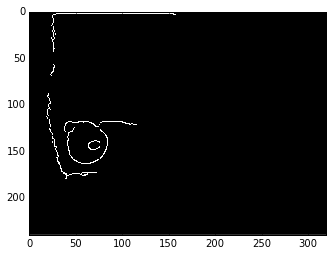

In [303]:
import copy
from scipy import ndimage as ndi
from scipy.misc import fromimage
from skimage import color
from skimage.draw import circle_perimeter
from skimage.feature import peak_local_max, canny
from skimage.filters.rank import median
from skimage.morphology import disk
from skimage.transform import hough_circle


image_list = []
filter_list = []

for i in range(T):
    image = fromimage(frame_list[i], True).astype(int)
    image_original = fromimage(frame_list[i])
#     blurred = median(image.astype("uint8"), disk(10))
    blurred = ndi.gaussian_filter(fromimage(frame_list[i], True).astype(int), 2)
    filtered = canny(blurred, sigma=1, low_threshold=10, high_threshold=120)
    
    image_list.append(image_original)
    filter_list.append(filtered)

image_list_corrected = copy.deepcopy(image_list)
image_list_clean = copy.deepcopy(image_list)

plt.figure()
plt.imshow(filtered) # Last filter in list

print(len(image_list))
print(len(filter_list))

#### Draw Circles
In order to detect centers outside the frame, the accumulator size is built to be larger than the original picture (roughly extended by two times the largest radius). Document the radius and x and y positions of each frame's center in _hdf_.

[255 255 255]
142 62


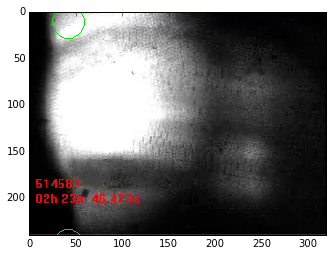

In [304]:
# Predict range of radii and then detect them based on previous filtering
hough_radii = np.arange(17, 30, 2) # [15 17 19 21 23 25 27 29]
hdf_xyr = []
hdf_color = []

for i in range(T):
    # Unsure whether to normalize accumulator
    hough_res = hough_circle(filter_list[i], hough_radii, True, False)

    centers = []
    accums = []
    radii = []

    for radius, h in zip(hough_radii, hough_res):
        # For each radius, extract num_peaks circles
        num_peaks = 1
        peaks = peak_local_max(h, num_peaks=num_peaks)
        centers.extend(peaks)
        accums.extend(h[peaks[:, 0], peaks[:, 1]])
        radii.extend([radius] * num_peaks)

    # Draw the most prominent circle
    # Change [:1] to any other number for number of circles
    for idx in np.argsort(accums)[::-1][:1]:
        center_y, center_x = centers[idx]
        radius = radii[idx]
        hdf_xyr.append([center_y, center_x, radius]) # may need to switch x's and y's
        hdf_color.append(image_list[i][center_y, center_x])
        cy, cx = circle_perimeter(center_y, center_x, radius)
        image_list[i][cy, cx] = (20, 220, 20)

print(image_list[720][center_y, center_x])
print(center_y, center_x)
plt.figure()
plt.imshow(image_list[720]) #i

In [302]:
# print(fromimage(frame_list[2400], True).astype("uint8"))

# iimg = median(iimg.astype(int), disk(10))
# iimg = ndi.gaussian_filter(fromimage(frame_list[700], True).astype(int), 2)
# plt.figure()
# plt.imshow(frame_list[3150])

# print(hdf_color[500])
# print(iimg)
# plt.figure()
# plt.imshow(canny(iimg.astype(int), sigma=1, low_threshold=10, high_threshold=120))

<a id='ecorr'></a>
## Error Correction
---
Remove any previous datasets (if they exist).

In [305]:
hdf_path = "xyrc_hdf/eye_position_data.hdf5"

if os.path.exists(hdf_path):
    os.remove(hdf_path)
else:
    print("HDF not created yet")

Create new HDF file from data.

In [306]:
import h5py

hdf_1 = np.asarray(hdf_xyr)
hdf_2 = np.asarray(hdf_color)

most_recent = 0
f = h5py.File(hdf_path, 'a')
dset_1 = f.create_dataset("dataset_%i" % most_recent, data=hdf_1, dtype='float64')
xyr_data = np.asarray(f.get("dataset_%i" % most_recent))

most_recent += 1
dset_2 = f.create_dataset("dataset_%i" % most_recent, data=hdf_2, dtype='float64')
color_data = np.asarray(f.get("dataset_%i" % most_recent))

Filter HDF ([x, y, r]).

In [310]:
from scipy.signal import medfilt

def nan_vector_outliers(vector, function=np.percentile, vmax=95.0, make_abs=False):
    preproc = np.abs if make_abs else lambda x: x
    maxval = function(preproc(vector), vmax)
    mask = np.where(vector > maxval, True, False)
    nvector = vector.copy()
    nvector[mask] = np.nan
    return nvector

def filter_pupil_location(posxyz, error_check, frame_no, medianfilt_window_size=15, filter_pupil=True,
                          nan_outliers=(0, 1, 2),
                          nan_functions=(np.percentile, np.percentile, np.percentile),
                          nan_vmax=(95., 95., 98.)):
    '''
    
    '''
    cleanxyz = posxyz.copy()
    xypos = cleanxyz[:, :-1]
    pupil_size = cleanxyz[:, -1]

    for sidx in range(2):
        xypos[:, sidx] = medfilt(xypos[:, sidx], medianfilt_window_size)

    if filter_pupil:
        pupil_size = medfilt(pupil_size, medianfilt_window_size+10)

#     for i in range(frame_no):
#         if error_check[i][0] > 140:
#             cleanxyz[i][0] = np.nan
            
#     for idx in nan_outliers:
#         vec = nan_vector_outliers(cleanxyz[:, idx],
#                                   function = nan_functions[idx],
#                                   vmax = nan_vmax[idx])
#         cleanxyz[:,idx] = vec

#     # Propagate nans
#     mask = np.isnan(cleanxyz.sum(axis = -1))
#     cleanxyz[mask] = np.nan

    return cleanxyz

posxyz_preproc = filter_pupil_location(xyr_data, color_data, T, medianfilt_window_size=5)
print(posxyz_preproc)

[[ 140.   62.   21.]
 [ 140.   62.   21.]
 [ 140.   62.   21.]
 ..., 
 [ 142.   62.   21.]
 [ 142.   62.   21.]
 [ 142.   62.   21.]]


<a id='wvid'></a>
## Write_Video
---
Take all the overwritten frames from the previous section and write them into video in **/out_filtered**.

In [78]:
import skvideo.io


tracked_path = "out_tracked/output_tracked.mp4"
skvideo.io.vwrite(tracked_path, image_list, 
                  inputdict={'-r': '60'}) # change to make fps more choppy

if video_show:
    HTML("""<video width="320" height="240" controls>
                <source src={0} type="video/{1}">
                    </video>""".format(tracked_path, video_format))

# check sec 12, 43 for blinks

Recreate video for (hopefully) improved results.

In [311]:
pp = posxyz_preproc.copy()

for i in range(T):
    if np.isnan(pp[i][0]):
        continue
    center_x = pp[i][1]
    center_y = pp[i][0]
    radius = pp[i][2]
    cy, cx = circle_perimeter(int(center_y), int(center_x), int(radius))
    image_list[i][cy, cx] = (220, 20, 150)
    image_list_corrected[i][cy, cx] = (220, 20, 150)

overlapped_path = "out_tracked/output_overlapped.mp4"
skvideo.io.vwrite(overlapped_path, image_list,
                  inputdict={'-r': '60'}) # change to make fps more choppy

filtered_path = "out_tracked/output_filtered.mp4"
skvideo.io.vwrite(filtered_path, image_list_corrected,
                  inputdict={'-r': '60'}) # change to make fps more choppy

In [309]:
image_list = copy.deepcopy(image_list_clean)
image_list_corrected = copy.deepcopy(image_list_clean)

#### Display Videos (not working)

In [ ]:
if video_show:
    HTML("""<video width="320" height="240" controls>
                <source src={0} type="video/{1}">
                </video>""".format(overlapped_path, video_format))

video_show_switch()
if video_show:
    print("displaying 2 videos...")
    html_show(filtered_path, video_format)
    HTML("""<video width="320" height="240" controls>
              <source src={0} type="video/{1}">
              </video>""".format(tracked_path, video_format))

<a id='warpf'></a>
## Warp_Field
---
Conducting pre-warp preparations; grabbing calibration frames, stimuli. Creating stimulus array. Only Python 2.x can use _cpickle_.

In [ ]:
import pickle


# def load_stimulus(stim_path='calibration_matrix/eyetrack.index', nrepeats=2):
#     '''
    
#     '''
#     stimulus_size = (1024, 768)
#     stimulus_fps = 15 # Hz
#     nstimuli = 35
#     target_duration = 2 # [sec]
#     stim_sizex, stim_sizey = stimulus_size

#     # [secs] 35 stimuli, 2s each, 2 repeats
#     stimulus_duration = float(nstimuli*nrepeats*target_duration)
#     # load the stimulus presentation file
#     stimulus_order = np.loadtxt(stim_path, dtype='S')
#     # which stimulus is presented when, zero-indexed transform
#     stimulus_order = np.asarray([int(os.path.splitext(t)[0][2:]) for t in stimulus_order]) -1
#     return stimulus_duration, stimulus_order

# load_stimulus()

z_path = open("calibration_matrix/1024x576_locations_hx00p_wx00p.p", "rb")
z = np.asarray(pickle.load(z_path))
ti = np.linspace(-2.0, 2.0, 100)
XI, YI = np.meshgrid(ti, ti)

#### Interpolate
Running _scipy.interpolate_'s thin-plate spline. Presenting as _meshgrid_.

In [ ]:
from scipy.interpolate import Rbf as rbf
from matplotlib import cm


rbf_horiz = rbf(image_list_copy[:, 1],
                image_list_copy[:, 0],
                target_locations_kept[:, 0],
                function='thin-plate',)

rbf_vert = rbf(image_list_copy[:, 1],
               image_list_copy[:, 0],
               z[:, 1],
               function='thin-plate',)

ZI = rbf(XI, YI)

plt.subplot(1, 1, 1)
plt.pcolor(XI, YI, ZI, cmap=cm.jet)
plt.scatter(x, y, 100, z, cmap=cm.jet)
plt.title("RBF interpolation")
plt.xlim(-2, 2)
plt.ylim(-2, 2)
plt.colorbar()

## Questions
---

* Blank out samples at beginning and end of trial, posxyz_targets[:, :trimbeg, :] = np.nan, posxyz_targets[:, -trimend:, :] = np.nan, posxyz_preproc = np.vstack(posxyz_targets)
* Blank out invalid points, posxyz_preproc[~valid] = np.nan
* 2 seconds each calibration frame?
* Color cross-validation
* Ellipsis use?
* Effectiveness of canny filter over median blur
* Way to mark blinks --> skvideo.motion.blockMotion?
* zscore